In [2]:
## Miscelaneous
import numpy as np
import os
import sys
import collections
import matplotlib.pyplot as plt
import loompy
from collections import Counter
from tqdm import tqdm

import pybedtools
from pybedtools import BedTool

import subprocess

import chromograph
from chromograph.peak_calling.utils import *
from chromograph.pipeline.utils import *
from chromograph.plotting.marker_plot import marker_plot
from chromograph.plotting.peak_annotation_plot import plot_peak_annotation_wheel
from chromograph.pipeline import config

import cytograph as cg
from cytograph.plotting.colors import colorize
from cytograph.enrichment import FeatureSelectionByMultilevelEnrichment
from cytograph.species import Species

import fisher

from typing import *

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.stats as stats
import scipy
from statsmodels.sandbox.stats.multicomp import multipletests

import logging
logger = logging.getLogger()
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%H:%M:%S')

config = config.load_config()

In [70]:
a, b, c = [[],[],[]]
a

[]

In [30]:
file_m = '/fish/other_tmp/camiel_tmp/Greenleaf/GSE129785_scATAC-Hematopoiesis-All.mtx'
file_b = '/fish/other_tmp/camiel_tmp/Greenleaf/GSE129785_scATAC-Hematopoiesis-All.cell_barcodes.txt.gz'
file_p = '/fish/other_tmp/camiel_tmp/Greenleaf/GSE129785_scATAC-Hematopoiesis-All.peaks.txt.gz'

mat = scipy.io.mmread(file_m)

In [31]:
import pandas as pd
barcodes = pd.read_table(file_b)
peaks = pd.read_csv(file_p)


In [32]:
col_attrs = {k: np.array(barcodes[k]) for k in barcodes}
del row_attrs

for x in peaks['Feature']:
    if 'row_attrs' not in locals():
        row_attrs = {}
        chrom, start, end = x.split('_')
        row_attrs['ID'] = [f'{chrom}:{start}-{end}']
        row_attrs['Chr'] = [chrom]
        row_attrs['Start'] = [start]
        row_attrs['End'] = [end]
    else:
        chrom, start, end = x.split('_')
        row_attrs['ID'].append(f'{chrom}:{start}-{end}')
        row_attrs['Chr'].append(chrom)
        row_attrs['Start'].append(start)
        row_attrs['End'].append(end)

In [33]:
filename = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.loom'

loompy.create(filename, mat, row_attrs, col_attrs)

In [43]:
from chromograph.peak_analysis.utils import *

filename = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.loom'
out_file = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.agg.loom'

agg_spec = {
    "Group": "tally",
    "Clusters": "first",
    "FRIP": "mean",
    "depth": "mean"
}

with loompy.connect(filename) as ds:
    ds.ca.Clusters = np.array([int(x.strip('Cluster')) for x in ds.ca.Clusters])
    ds.aggregate(out_file, None, "Clusters", "sum", agg_spec)
    
    with loompy.connect(out_file) as dsout:

        logging.info('Calculate coverage metrics')
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]

        ## Normalize peak counts by total fragments per cluster
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

        ## Call positive and negative peaks for every cluster
        dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout)


19:39:35 INFO     Calculate coverage metrics
19:39:41 INFO     Convert to CPMs
19:39:44 INFO     Binarize peak matrix
100%|██████████| 31/31 [00:26<00:00,  1.15it/s]


14:37:01 INFO     Shape (571400, 31)


0

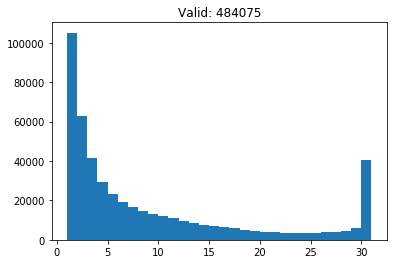

In [109]:
threshold = 1

out_file = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.agg.loom'
bed_file = '/fish/other_tmp/camiel_tmp/Greenleaf/active_elements.hg19.bed'
lifted_file = '/fish/other_tmp/camiel_tmp/Greenleaf/active_elements.hg38.bed'
unlifted = '/fish/other_tmp/camiel_tmp/Greenleaf/unlifted.bed'
with loompy.connect(out_file) as dsagg:
    logging.info(f'Shape {dsagg.shape}')
    Valids = []
    binary = dsagg['CPM'][:,:] > threshold
    ON = np.sum(binary[:,:], axis=1)
    Valids = ON > 0
    plt.figure()
    plt.title(f'Valid: {np.sum(Valids)}')
    plt.hist(ON[Valids], bins= 30)
    
with loompy.connect(out_file) as ds:
    enh = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in np.where(Valids)[0]]).saveas(bed_file)
    
subprocess.call(['/home/camiel/anaconda3/envs/DNA_tools/bin/liftOver', bed_file, '/data/proj/scATAC/ref/hg19ToHg38.over.chain.gz', lifted_file, unlifted])
subprocess.call(['rm', unlifted])

## Lake data

In [ ]:
from scipy import sparse

for Tissue in ['Fcx1', 'Occ1', 'Cbh1']:

    logging.info(f'Start on tissue: {Tissue}')

    ## Recovering matrix from bam files
    f_dir = f'/fish/other_tmp/camiel_tmp/Lake/{Tissue}/bams'
    files = os.listdir(f_dir)

    barcodes = []
    Counts = {}
    peak_dict ={}

    with open(os.path.join(f_dir, files[0])) as fi:
        for i, line in enumerate(fi):
            if i > 0:
                peak_dict[line.split()[0]] = i - 1

    cnt = 0
    for f in files:
        b = f'{f.split(".")[0]}_{f.split(".")[2].split("_")[0]}'
        if b.endswith('H'):
            b = b.strip('H')
        barcodes.append(b)
        with open(os.path.join(f_dir, f)) as fi:
            for i, line in enumerate(fi):
                if i > 0:
                    fields = line.split()
                    count = int(fields[1])
                    if count > 0:
                        if b not in Counts:
                            Counts[b] = {fields[0]:fields[1]}
                        else:
                            Counts[b][fields[0]] = fields[1]
        cnt += 1
        if cnt%2000==0:
            logging.info(cnt)

    annot = {'ID': np.array([x for x in peak_dict])}

    c, s, e = [[],[],[]]
    for x in annot['ID']:
        chrom, loc = [k.split('-') for k in x.split(':')]
        c.append(chrom[0])
        s.append(loc[0])
        e.append(loc[1])

    annot['Chr'], annot['Start'], annot['End'] = [np.array(x) for x in [c, s, e]]

    meta = np.loadtxt('/fish/other_tmp/camiel_tmp/Lake/Lake_metadata.csv', delimiter=';', skiprows=1, dtype=str)
    cols = {'barcode':np.array(meta[:,0]), 'Shortname':np.array(meta[:,3]), 'Tissue':np.array(meta[:,4]), 'Clusters':np.array(meta[:,6]), 'Clusters2':np.array(meta[:,5])}

    logging.info("Generating Sparse matrix")
    col = []
    row = []
    v = []
    cix = 0
    IDs = []
    for cell in Counts:
        if cell in cols['barcode']:
            if len(Counts[cell]) > 0:
                for key in (Counts[cell]):
                    col.append(cix)
                    row.append(peak_dict[key])
                    v.append(np.int8(Counts[cell][key]))
                cix+=1
                IDs.append(cell)

    matrix = sparse.coo_matrix((v, (row,col)), shape=(len(peak_dict.keys()), cix)).tocsc()
    logging.info(f'Matrix has shape {matrix.shape} with {matrix.nnz} elements')

    Valid = [x in IDs for x in cols['barcode']]
    cols = {k: cols[k][Valid] for k in cols}
    cols['CellID'] = np.array([f'{cols["Shortname"][x]}:{cols["barcode"][x]}' for x in range(len(cols['barcode']))])
    ID_dict = {k: v for v, k in enumerate(IDs)}
    reorder = [ID_dict[k] for k in cols['barcode']]
    cols = {k: cols[k][reorder] for k in cols}

    out_file = f'/fish/other_tmp/camiel_tmp/Lake/{Tissue}/Lake_{Tissue}.loom'
    loompy.create(filename=out_file, 
                  layers=matrix, 
                  row_attrs=annot, 
                  col_attrs=cols)
    logging.info(f'Saved file as {out_file}')

18:57:01 INFO     Start on tissue: Fcx1
19:03:05 INFO     2000
19:09:24 INFO     4000
19:15:27 INFO     6000
19:20:52 INFO     8000
19:20:57 INFO     Generating Sparse matrix
19:21:01 INFO     Matrix has shape (287381, 6630) with 1190710 elements
19:21:42 INFO     Saved file as /fish/other_tmp/camiel_tmp/Lake/Fcx1/Lake_Fcx1.loom
19:21:42 INFO     Start on tissue: Occ1
19:27:10 INFO     2000
19:32:34 INFO     4000
19:38:30 INFO     6000
19:44:15 INFO     8000
19:49:47 INFO     10000
19:55:47 INFO     12000
20:01:26 INFO     14000
20:03:52 INFO     Generating Sparse matrix
20:04:10 INFO     Matrix has shape (287381, 14870) with 8864408 elements


In [ ]:
files = [os.path.join('/fish/other_tmp/camiel_tmp/Lake/', Tissue, f'Lake_{Tissue}.loom') for Tissue in ['Fcx1', 'Occ1', 'Cbh1']]
merge_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.loom'

loompy.combine_faster(files, merge_file)

In [ ]:
out_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.agg.loom'
merge_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.loom'
agg_spec = {
    "Group": "Tissue",
    "Clusters": "first",
    "ClusterNames": "first",
    "Shortname": "tally"
}

with loompy.connect(merge_file) as ds:
    ds.ca.ClusterNames = ds.ca.Clusters
    enum = {k:v for v, k in enumerate(np.unique(ds.ca.ClusterNames))}
    ds.ca.Clusters = np.array([enum[x] for x in ds.ca.ClusterNames])
    ds.aggregate(out_file, None, "Clusters", "sum", agg_spec)
    
    with loompy.connect(out_file) as dsout:

        logging.info('Calculate coverage metrics')
        dsout.ca.Total = dsout.map([np.sum], axis=1)[0]
        dsout.ra.NCells = dsout.map([np.sum], axis=0)[0]

        ## Normalize peak counts by total fragments per cluster
        logging.info('Convert to CPMs')
        dsout.layers['CPM'] = div0(dsout[''][:,:], dsout.ca.Total * 1e-6)

        ## Call positive and negative peaks for every cluster
        dsout['binary'], dsout.ca['CPM_thres'] = KneeBinarization(dsout)


In [ ]:
threshold = 1

out_file = '/fish/other_tmp/camiel_tmp/Lake/Lake_scTHS_seq.agg.loom'
bed_file = '/fish/other_tmp/camiel_tmp/Lake/active_elements.hg38.bed'
with loompy.connect(out_file) as dsagg:
    logging.info(f'Shape {dsagg.shape}')
    Valids = []
    binary = dsagg['CPM'][:,:] > threshold
    ON = np.sum(binary[:,:], axis=1)
    Valids = ON > 0
    plt.figure()
    plt.title(f'Valid: {np.sum(Valids)}')
    plt.hist(ON[Valids], bins= 30)
    
with loompy.connect(out_file) as ds:
    enh = BedTool([(ds.ra['Chr'][x], str(ds.ra['Start'][x]), str(ds.ra['End'][x]), str(ds.ra['ID'][x])) for x in np.where(Valids)[0]]).saveas(bed_file)

In [ ]:
with loompy.connect(out_file) as ds:
    print(ds.ra.Chr[:10])

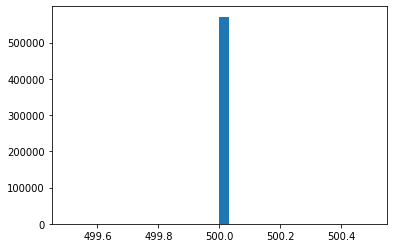

In [4]:
out_file = '/fish/other_tmp/camiel_tmp/Greenleaf/Greenleaf_peaks.agg.loom'

with loompy.connect(out_file) as dsagg:
    plt.hist(dsagg.ra.End.astype('int') - dsagg.ra.Start.astype('int'), bins=30)